In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib

In [2]:
df = pd.read_csv('Events.csv')

In [3]:
df = df[(df['t0']>9700)&(df['chi2']!=0)&(df['chi2']<0.5)]

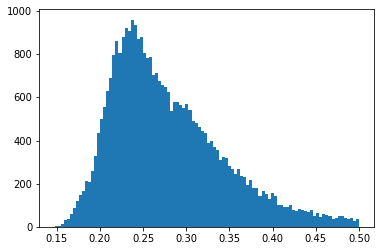

In [4]:
plt.hist(df['chi2'],bins=100)
plt.show()

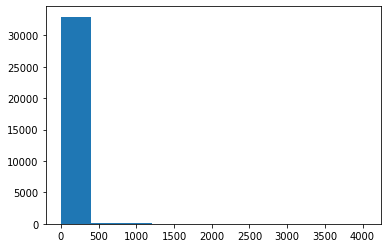

In [5]:
plt.hist(df['sigmat0'])
plt.show()

In [6]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x',
       'Laputop_pos_y'],
      dtype='object')

In [7]:
r = ((df['x'].values-df['ShowerCOG_x'].values)**2.0 + (df['y'].values-df['ShowerCOG_y'].values)**2.0 + (df['z'].values-df['ShowerCOG_z'].values)**2.0)**0.5

In [8]:
for i in range(len(r)):
    if df['ShowerCOG_time'].values[i] < df['t0'].values[i]:
        r[i] = r[i]
    else:
        r[i] = -r[i]

In [9]:
df['r'] = r

In [10]:
c = .299

In [11]:
def get_delta(r,a,b,sigma):
    delta = a * r**2.0 #+ b * (1-np.exp(-(r**2.0)/(2*sigma**2.0)))
    return delta

In [12]:
def get_n(x,y,z):
    x,y,z = np.array([x,y,z])/(x**2.0+y**2.0+z**2.0)**0.5
    return [x,y,z]

In [13]:
def get_t(X,x1,y1,z1,a,b,sigma,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x1 = (x-xc)*n[0]
    x2 = (y-yc)*n[1]
    x3 = (z-zc)*n[2] 
    new = x1 + x2 + x3
    t = tc + (1/c)*np.array(new) + get_delta(r,a,b,sigma)
    return t

In [14]:
def get_angular_resolution(x1,y1,z1,x2,y2,z2):
    n1 = np.array(get_n(x1,y1,z1))
    n2 = np.array(get_n(x2,y2,z2))
    if np.dot(n1,n2)>1:
        value = 1
        angular_res = np.arccos(value)*180/np.pi
    else:
        angular_res = np.arccos(np.dot(n1,n2))*180/np.pi
    return angular_res

In [15]:
from scipy.optimize import curve_fit

In [16]:
from functools import partial

In [17]:
events = df['Unnamed: 0'].unique()

In [18]:
from sklearn.cluster import MeanShift

In [19]:
def clean(event1,check1):
    cluster = MeanShift()
    cluster.fit(np.array(event1['m']).reshape(-1,1),event1['s'])
    labels = cluster.labels_
    max_value = list(set(labels))[-1:]
            
    cluster2 = MeanShift()
    cluster2.fit(np.array(event1['x']).reshape(-1,1),event1['y'])
    labels2 = cluster2.labels_
    max_value2 = list(set(labels))[-1:]
    
    removed = []
            
    for i in range(len(check1)):
        if check1[i] & ((labels[i] in max_value) or (labels2[i] in max_value2)):
            check1[i] = False
            removed.append(i)
    return check1,removed

In [20]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [21]:
laputop_zenith = []
laputop_azimuth = []
mc_zenith = []
mc_azimuth = []
angular_resolution = []
for event in events:
    event1 = df.loc[df['Unnamed: 0'] == event]
    laputop_zenith.append(event1['Laputop_dir_zenith'].values[0])
    laputop_azimuth.append(event1['Laputop_dir_azimuth'].values[0])
    mc_zenith.append(event1['zenith'].values[0])
    mc_azimuth.append(event1['azimuth'].values[0])
    angular_resolution.append(event1['angular_resolution'].values[0])

In [146]:
ang_res = []
laputop_res = []
residuals = []
energy = []
zenith = []

def get_fit(event):

    event1 = df.loc[df['Unnamed: 0'] == event]
    #event1 = event1.loc[abs(event1['r'])>50]
    
    energy = event1['energy'].values[0]
    zenith = event1['zenith'].values[0]
    true_zen = event1['zenith'].values[0]
    true_az = event1['azimuth'].values[0]
    
    true_x = -np.sin(true_zen) * np.cos(true_az)
    true_y = -np.sin(true_zen) * np.sin(true_az)
    true_z = -np.cos(true_zen)

    tc = event1['ShowerCOG_time'].values[0]
    xc = event1['ShowerCOG_x'].values[0]
    yc = event1['ShowerCOG_y'].values[0]
    zc = event1['ShowerCOG_z'].values[0]
    zen_shower = event1['ShowerCOG_zen'].values[0]
    az_shower = event1['ShowerCOG_az'].values[0]
    
    first_x = -np.sin(zen_shower) * np.cos(az_shower)
    first_y = -np.sin(zen_shower) * np.sin(az_shower)
    first_z = -np.cos(zen_shower) 
    
    x_o = event1['x'].values
    y_o = event1['y'].values
    z_o = event1['z'].values
    r_o = event1['r'].values
    t0_o = event1['t0'].values
    
    get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)
    
    check = [True for i in range(len(event1))]
    
    fit_old = curve_fit(get_t_new,(x_o,y_o,z_o,r_o),t0_o,
                    p0=[-0.5,-0.5,-0.5,4.823*10**-4,19.51,83.5],
                    bounds=((-1,-1,-1,0,0,0),(0,0,0,1,200,200)),
                    maxfev=2000)
    
    ang_res_fit_o = get_angular_resolution(fit_old[0][0],fit_old[0][1],fit_old[0][2],true_x,true_y,true_z)
    
    count = 0
    remove_index_list = []

    fit_list = []
    fit_list.append(fit_old)
    
    ang_res_list = []
    ang_res_list.append(ang_res_fit_o)
    
    while True:
        if count == 0:
            check1 = np.copy(check)
        else:
            check1[remove_index] = False

        ang_list_test = []
        fit_check = []
        
        for i in np.array(range(len(check1))):
            check2 = np.copy(check1)
            check2[i] = False
            
            if i in remove_index_list:
                ang_list_test.append(np.inf)
                fit_check.append(fit_old)
                continue

            x = event1['x'].values[check2]
            y = event1['y'].values[check2]
            z = event1['z'].values[check2]
            r = event1['r'].values[check2]
            t0 = event1['t0'].values[check2]
    
            get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)
        
            fit = curve_fit(get_t_new,(x,y,z,r),t0,
                            p0=[-0.5,-0.5,-0.5,4.823*10**-4,19.51,83.5],
                            bounds=((-1,-1,-1,0,0,0),(0,0,0,1,200,200)),
                            maxfev=2000)
            
            ang_res_new = get_angular_resolution(fit[0][0],fit[0][1],fit[0][2],true_x,true_y,true_z)
            ang_list_test.append(ang_res_new)
            fit_check.append(fit)
            
        remove_index = np.argmin(ang_list_test)
        remove_index_list.append(remove_index)

        check1[remove_index]=False
        
        fit_new = fit_check[remove_index]
        fit_list.append(fit_new)
        
       
        ang_res_new = get_angular_resolution(fit_new[0][0],fit_new[0][1],fit_new[0][2],true_x,true_y,true_z)

        ang_res_list.append(ang_res_new)
        
        if (ang_res_new>ang_res_list[-2]) or (np.sum(check1==0)>3):
            check1[remove_index] = True
            ang_res_final=ang_res_list[-2]
            
            lap_az = event1['Laputop_dir_azimuth'].values[0]
            lap_zen = event1['Laputop_dir_zenith'].values[0]
            lapx = -np.sin(lap_zen)*np.cos(lap_az)
            lapy = -np.sin(lap_zen)*np.sin(lap_az)
            lapz = -np.cos(lap_zen)
            laputop = get_angular_resolution(lapx,lapy,lapz,true_x,true_y,true_z)
            break
        count+=1  
        
        
    return event,check1,ang_res_final
        
    

In [147]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [148]:
import time

In [149]:
our_dict = {}
count = 0
for event in events:
    if count == 100:
        print(count)
        count = 0
    time1 = time.time()
    try:
        event_name,check1,ang_res_final = get_fit(event)
    except RuntimeError:
        count+=1
        continue
    our_dict[event_name] = {}
    our_dict[event_name]['check'] = check1
    our_dict[event_name]['ang_res_final'] = ang_res_final
    time2 = time.time()
    count+=1

100
100
100
100
100
100
100
100
100
100


In [150]:
np.save('best_labels',our_dict)

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from keras.preprocessing.sequence import pad_sequences

In [161]:
def clean(event1):
    event1 = df[df['Unnamed: 0']==event1]
    doms = []
    strings = []
    chi2 = []
    remove_index_list = []
    for value in range(len(event1)):
        doms.append(event1['Unnamed: 1'].values[value].split(',')[1])
        strings.append(event1['Unnamed: 1'].values[value].split(',')[0].split('(')[1])
        chi2.append(event1['chi2'].values[value])
    doms = np.array(doms)
    strings = np.array(strings)
    chi2 = np.array(chi2)
    
    check = []
    for string in np.unique(strings):
        if np.sum(strings==string)==2:
            index_max = np.argmax(chi2[strings==string])
            if index_max == 0:
                check.append(False)
            else:
                check.append(True)
            if check[-1]:
                check.append(False)
            else:
                check.append(True)
        else:
            check.append(True)
            
    for i in range(len(check)):
        cutoff = np.mean(chi2[check])+2*np.mean(chi2[check])/len(chi2[check])
        if (chi2[i]>=cutoff):
            check[i] = False
    
    for i in range(len(check)):
        if not check[i]:
            remove_index_list.append(i)
    return check

In [162]:
X = []
y = []
for i in events:
    check = clean(i)
    X.append(df[df['Unnamed: 0']==i]['t0'].values[check])
    y.append(df[df['Unnamed: 0']==i]['zenith'].values[0])

In [163]:
length = [len(i) for i in X]

In [164]:
new_X = pad_sequences(X)

In [165]:
X_train,X_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.2,random_state=16)

In [168]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42))]

In [169]:
classifier = StackingRegressor(estimators=estimators)

In [170]:
classifier.fit(X_train,y_train)

/home/andy/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/andy/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/andy/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/andy/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/andy/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

StackingRegressor(cv=None,
                  estimators=[('lr',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                       cv=None, fit_intercept=True,
                                       gcv_mode=None, normalize=False,
                                       scoring=None, store_cv_values=False)),
                              ('svr',
                               LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss='epsilon_insensitive',
                                         max_iter=1000, random_state=42,
                                         tol=0.0001, verbose=0))],
                  final_estimator=None, n_jobs=None, passthrough=False,
                  verbose=0)

In [171]:
pred = classifier.predict(X_test)

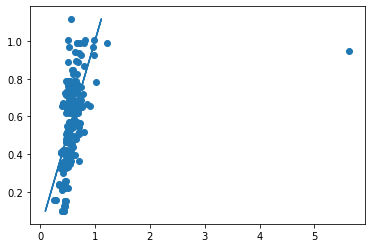

In [172]:
plt.scatter(pred,y_test)
plt.plot(y_test,y_test)
plt.show()

In [173]:
diff = [abs(i-j)*180/np.pi for i,j in zip(pred,y_test)]

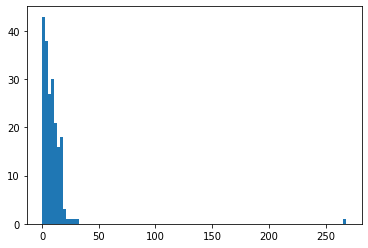

In [174]:
plt.hist(diff,bins=100)
plt.show()

In [158]:
len(y_test)

201